In [1]:
import mdtraj as md
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from funcs_validate_msm import *
from funcs_build_msm import get_data 
from natsort import natsorted

In [2]:
protein = 'abl'
save_dir = Path(f'data_{protein}/plots/')
sample_dir = Path(f'data_{protein}/samples/')

In [3]:
f_dunbrack = natsorted([str(d) for d in Path(f'./data_{protein}/ftrajs/').glob('run*-clone*_dbdist.npy')])
dbdist, traj_mapping = get_data(trajlen_cutoff=1000, features=['dbdist'], ftraj_dir=Path(f'data_{protein}/ftrajs'))
dbdist_cat = np.concatenate(dbdist)
sliced_ftraj = dbdist_cat[::500, 0:2]*10
sliced_ftraj.shape

Loading feature:  dbdist


100%|██████████| 749/749 [00:00<00:00, 8403.69it/s]

Loaded number of ftrajs: 416


(23413, 2)

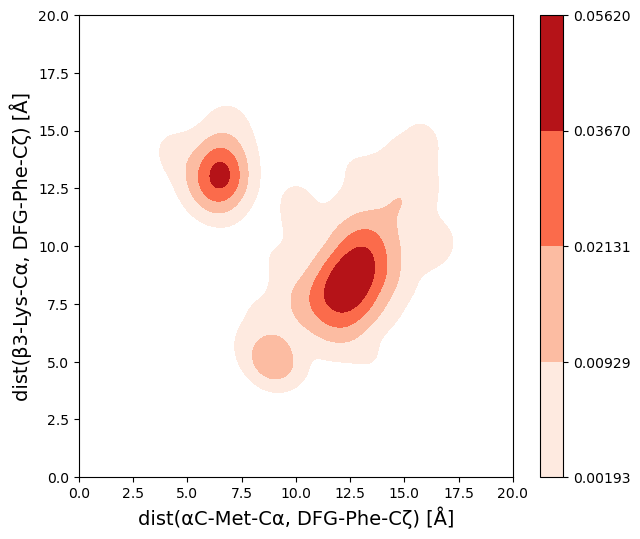

In [6]:
data = pd.DataFrame(sliced_ftraj, columns=['dist(Cα-Glu(+4)-Cα, DFG-Phe-Cζ)', 'dist(β3-Lys-Cα, DFG-Phe-Cζ)'])

fig, ax = plt.subplots(figsize=(7, 6))
sns.kdeplot(data=data, ax=ax, x='dist(Cα-Glu(+4)-Cα, DFG-Phe-Cζ)', y='dist(β3-Lys-Cα, DFG-Phe-Cζ)', cbar=True, fill=True, cmap='Reds', levels=5)
ax.set_xlabel('dist(αC-Met-Cα, DFG-Phe-Cζ) [Å]', fontsize=14)
ax.set_ylabel('dist(β3-Lys-Cα, DFG-Phe-Cζ) [Å]', fontsize=14)
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.savefig(save_dir / 'dfg_hist.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

Apply average linkage hierarchical clustering to the point cloud:

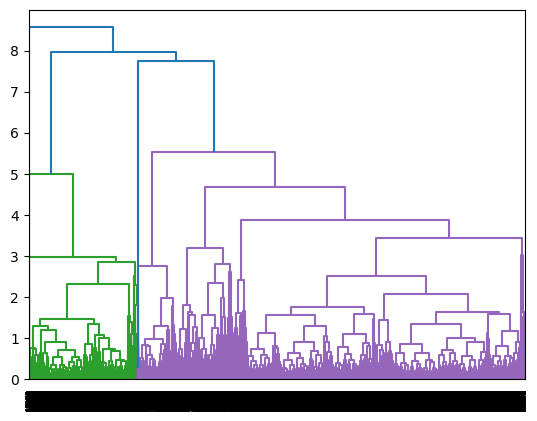

In [7]:
Z = linkage(sliced_ftraj[:, :2], method='average')
R = dendrogram(Z)

In [8]:
cluster_labels = fcluster(Z, 3, criterion='maxclust')
cluster1_points = sliced_ftraj[:, :2][cluster_labels == 1]
cluster2_points = sliced_ftraj[:, :2][cluster_labels == 2]
cluster3_points = sliced_ftraj[:, :2][cluster_labels == 3]

cluster_labels.dump('spatial_group_labels.npy')

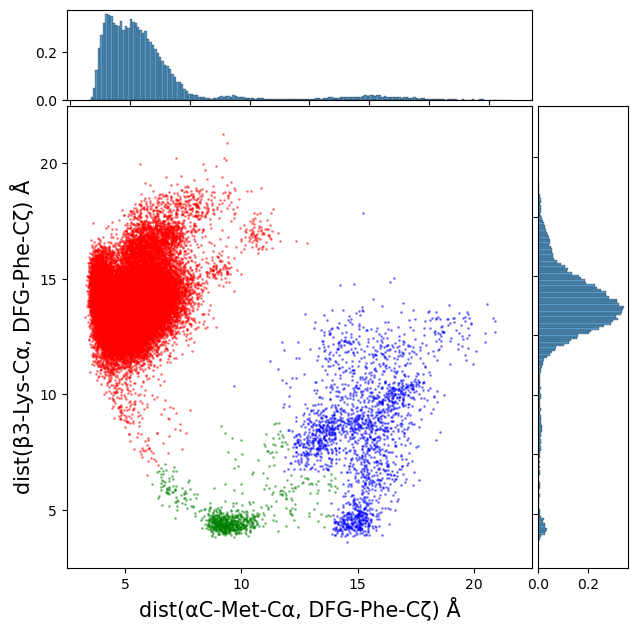

In [112]:
# Top left -- DFG-in
# Bottom right -- DFG-out
# Bottom -- DFG-inter

fig, ax = plt.subplots(figsize=(6, 6))
intx_ax = fig.add_axes([ax.get_position().x0, ax.get_position().y1 + 0.01,
                        ax.get_position().width, 0.15])
inty_ax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0,
                        0.15, ax.get_position().height])

ax.scatter(cluster1_points[:,0]*10, cluster1_points[:,1]*10, s=1, alpha=0.4, c='r')
ax.scatter(cluster2_points[:,0]*10, cluster2_points[:,1]*10, s=1, alpha=0.4, c='g')
ax.scatter(cluster3_points[:,0]*10, cluster3_points[:,1]*10, s=1, alpha=0.4, c='b')

sns.histplot(x=sliced_ftraj[:, 0]*10, stat='density', lw=3, ax=intx_ax)
sns.histplot(y=sliced_ftraj[:, 1]*10, stat='density', lw=3, ax=inty_ax)

ax.set_xlabel('dist(αC-Met-Cα, DFG-Phe-Cζ) Å', fontsize=15)
ax.set_ylabel('dist(β3-Lys-Cα, DFG-Phe-Cζ) Å', fontsize=15)
ax.set_xlim(2.5, 22.5)
ax.set_ylim(2.5, 22.5)
ax.set_xticks(np.arange(5, 25, 5))
ax.set_yticks(np.arange(5, 25, 5))
intx_ax.set_ylabel('')
intx_ax.tick_params(labelbottom=False)
inty_ax.set_xlabel('')
inty_ax.tick_params(labelleft=False)

plt.savefig(save_dir / 'dfg_dist_clusters.png', dpi=300, transparent=True)
plt.show()

In [35]:
d1 = [ftraj[:, 0] for ftraj in ftrajs_dist]
d2 = [ftraj[:, 1] for ftraj in ftrajs_dist]

In [68]:
dfg_in_samples = sample_frames_by_features([d1,d2], [[0.25,1],[1,2]], 20)
dfg_inter_samples = sample_frames_by_features([d1,d2], [[0.75,1.25],[0.25,0.6]], 20)
dfg_out_samples = sample_frames_by_features([d1,d2], [[1.3,2],[0.75,1.25]], 20)

In [111]:
save_samples(dfg_in_samples, traj_files, sample_dir / 'dfg_in_samples.pdb')
save_samples(dfg_inter_samples, traj_files, sample_dir / 'dfg_inter_samples.pdb')
save_samples(dfg_out_samples, traj_files, sample_dir / 'dfg_out_samples.pdb')

### Is there a DFG flipped trajectory in out simulations? 

In [11]:
dbdist, traj_mapping = get_data(trajlen_cutoff=1000, features=['dbdist'], ftraj_dir=Path(f'data_{protein}/ftrajs'))

Loading feature:  dbdist


100%|██████████| 3472/3472 [00:00<00:00, 14091.98it/s]

Loaded number of ftrajs: 1988


In [24]:
transition_ind = []
for i, traj in enumerate(dbdist):
    d1, d2 = traj[:, 0], traj[:, 1]
    is_open = np.logical_and(d1 < 0.9, d2 > 1)
    is_close = np.logical_and(d1 > 1.2, d1 < 1.2)
    if is_open.any() and is_close.any():
        transition_ind.append(i)
transition_ind

[]